# Will it be delayed?

Everyone who has flown has experienced a delayed or cancelled flight. Both airlines and airports would like to improve their on-time performance and predict when a flight will be delayed or cancelled several days in advance. You are being hired to build a model that can predict if a flight will be delayed. To learn more, you must schedule a meeting with your client (me). To schedule an appointment with your client, send an event request through Google Calendar for a 15 minute meeting. Both you and your project partner must attend the meeting. Come prepared with questions to ask your client. Remember that your client is not a data scientist and you will need to explain things in a way that is easy to understand. Make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

For this project you must go through most all steps in the checklist. You must write responses for all items as done in the homeworks, however sometimes the item will simply be "does not apply". Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Some changes to the checklist:

* Do not do the final part (launching the product).
* Your presentation will be done as information written in this document in a dedicated section (no slides or anything like that). It should include high-level summary of your results (including what you learned about the data, the "accuracy" of your model, what features were important, etc). It should be written for your client, not your professor or teammates. It should include the best summary plots/graphics/data points.
* The models and hyperparameters you should consider during short-listing and fine-tuning will be released at a later time (dependent on how far we get over the next two weeks).
* Data retrieval must be automatic as part of the code (so it can easily be re-run and grab the latest data). Do not commit any data to the repository.
* Your submission must include a pickled final model along with this notebook.

Frame the Problem and Look at the Big Picture
=============================================

1. **Define the objective in business terms:** 
    - The objective for this machine learning model is to be able to figure out whether a delay or cancellation is going to happen.
2. **How will your solution be used?**
    - This model will be used to help notify airlines  a week in advance when a suspected delay is going to happen as a preventative measure to help make sure airline companies have higher ratings and increased profits.
3. **What are the current solutions/workarounds (if any)?** 
    - Currently this is done by humans at each airport but is not as effective due to the massive amounts of data needed 
4. **How should you frame this problem?** 
    - This is a supervised classification problem since we are trying to predict whether a flight is going to run normal, be delayed or cancelled. This could be an online solution due to it being run in real time to predict future outcomes of flights.
5. **How should performance be measured? Is the performance measure aligned with the business objective?** 
    - Our objective is to be able to predict at least 25% of the flights that are going to be delayed or cancelled without falsely predicting any normal flights as going to be delayed or cancelled. This does align with out business objective of being able to predict when there is going to be a delayed or cancelled flight. 
6. **What would be the minimum performance needed to reach the business objective?** 
    - Again the minimum performance that would need to be predicted is 25% of the flights that are going to be delayed or cancelled accurately without falsely predicting that a normal flight is going to be delayed.
7. **What are comparable problems? Can you reuse (personal or readily available) experience or tools?** 
    - We can reuse our bike data as it is also a supervised classification problem. We also have our other homeworks and inclass examples to be able to work off of in terms of setting up the model.
8. **Is human expertise available?** 
    - Yes our client is has experience with flight delays and has provided us with good insight and direction on where to look into for our problem.
9. **How would you solve the problem manually?** 
    - To solve this problem manually we would need to look at all the data for what has caused delays and cancellations the most and calculate a way to see what airports get affected the most to be able to more accurately predict whether or not there is going to be a delay or cancellation.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** 
    - We have made the assumption that weather is going to play a massive role in whether there is going to be a delay or not. Also the size of the airport and number of staff is going to be important in whether an airport can even properly operate which could lead to delays.

Get the Data
============

1. **List the data you need and how much you need:**
    - National flight data for 2023 and 2024
    - Weather data covering all of the same dates, preferably daily.
2. **Find and document where you can get that data:**
    - All of the weather data is available on the NOAA website. You must go through and make an order for each individual airport. The link is here: https://www.ncei.noaa.gov/cdo-web/ 
    - Flight data is from: https://www.transtats.bts.gov/tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r 
3. **Get access authorizations**:
   - You must agree to the terms of use and make an order (which is free for digital use).
4. **Create a workspace**: This notebook.
5. **Get the data**: 
    - Download all of the CSV files from the websites mentioned above
6. **Convert the data to a format you can easily manipulate**:
   - The data is all in one parquet file.
7. **Ensure sensitive information is deleted or protected**: This is public data
8. **Check the size and type of data (time series, geographical, …)**:

<mark>TODO</mark>: report your information below. At this point, since you don't want to look at the data too closely, this is a quick evaluation about the number of features and their data types (note: remember that just because all values for a feature are a number doesn't mean that feature is numerical), the number of samples (including possible missing data), and any special considerations about the features such as:

   1. Is it a time series: 
      - Yes

   2. Are any of the features unusable for the business problem? Or are some not available for the business problem when the model will be used?: 
      - Yes, so far all of the features are usable except for diverted flights, because the client doesn't want those accounted

   3. Which feature(s) will be used as the target/label for the business problem? (including which are required to derive the correct label)
      

   4. Should any of the features be stratified during the train/test split to avoid sampling biases?
   

Do not look at the data too closely at this point since you have not yet split off the testing set. Basically, enough looking at it to understand *how* to split the test set off. It is likely you will have to review the website where the data came from to be able to understand some of the features.

In [1]:
#Imports
import numpy as np
import os
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 

In [2]:
def load_all_data():
    if os.path.exists('final_data.parquet'):
        print('final_data.parquet already exists, skipping all merging')
        data = pd.read_parquet('final_data.parquet')
        return data
    
    # Load the data
    data = pd.read_parquet('combined.parquet')
    columns_to_keep = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'OriginAirportID', 'Origin', 'OriginCityName', 'OriginStateName' ,'DestAirportID', 'Dest', 'DestCityName', 'DestStateName', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'Cancelled', 'CancellationCode', 'CarrierDelay', 'Tail_Number', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'AirTime', 'Flights', 'Distance']
    data = data[columns_to_keep]
    weather_df = pd.read_csv('3964079.csv')

    # Convert 'DATE' to datetime and extract date components
    weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
    weather_df['Year'] = weather_df['DATE'].dt.year
    weather_df['Month'] = weather_df['DATE'].dt.month
    weather_df['DayofMonth'] = weather_df['DATE'].dt.day

    # Rename 'STATION' to 'WeatherStation' for clarity
    weather_df.rename(columns={'STATION': 'WeatherStation'}, inplace=True)
   
    data['FlightDate'] = pd.to_datetime(data['FlightDate']) 
    airport_to_station = {
    'ATL': 'USW00013874',
    'ORD': 'USW00094846',
    'SEA': 'USW00024233',
    'MIA': 'USW00012839',
    'DFW': 'USW00003927',
    'LAX': 'USW00023174',
    'DEN': 'USW00003017',
    } 
    data['WeatherStation'] = data['Origin'].map(airport_to_station)

    aircraft = pd.read_csv('aircrafts.csv')

    # Merge the data
    combined_df = pd.merge(
    data,
    weather_df,
    on=['Year', 'Month', 'DayofMonth', 'WeatherStation'],
    how='left')

    combined_df['Tail_Number'] = combined_df['Tail_Number'].astype(str)
    aircraft['reg'] = aircraft['reg'].astype(str)

    final_data = pd.merge(
        combined_df,
        aircraft,
        left_on='Tail_Number',
        right_on='reg',
        how='left'
    )
    final_data.to_parquet('final_data.parquet')
    return final_data
    



In [3]:
data = load_all_data()


final_data.parquet already exists, skipping all merging


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825707 entries, 0 to 14825706
Data columns (total 78 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Year                   int64         
 1   Month                  int64         
 2   DayofMonth             int64         
 3   DayOfWeek              int64         
 4   FlightDate             datetime64[ns]
 5   OriginAirportID        int64         
 6   Origin                 object        
 7   OriginCityName         object        
 8   OriginStateName        object        
 9   DestAirportID          int64         
 10  Dest                   object        
 11  DestCityName           object        
 12  DestStateName          object        
 13  DepTime                float64       
 14  DepDelay               float64       
 15  DepDelayMinutes        float64       
 16  ArrTime                float64       
 17  ArrDelayMinutes        float64       
 18  Cancelled           

In [14]:
data.describe()

,Year,Month,DayofMonth,DayOfWeek,FlightDate,OriginAirportID,DestAirportID,DepTime,DepDelay,DepDelayMinutes,...,WT07,WT08,WT09,WT10,id,serial,numSeats,numEngines,ageYears,numRegistrations
count,1.482571e+07,1.482571e+07,1.482571e+07,1.482571e+07,14825707,1.482571e+07,1.482571e+07,1.463667e+07,1.463630e+07,1.463630e+07,...,5178.0,483125.0,5416.0,1047.0,1.421569e+07,1.418652e+07,9.078130e+06,1.383126e+07,1.332507e+07,1.421569e+07
mean,2.023509e+03,6.586377e+00,1.577153e+01,3.983661e+00,2024-01-06 02:34:45.840818944,1.265432e+04,1.265433e+04,1.332564e+03,1.235834e+01,1.565029e+01,...,1.0,1.0,1.0,1.0,4.397632e+05,2.675482e+06,1.431214e+02,2.000781e+00,1.456669e+01,1.489753e+00
min,2.023000e+03,1.000000e+00,1.000000e+00,1.000000e+00,2023-01-01 00:00:00,1.013500e+04,1.013500e+04,1.000000e+00,-9.900000e+01,0.000000e+00,...,1.0,1.0,1.0,1.0,3.390000e+02,2.400000e+01,1.000000e+00,2.000000e+00,3.000000e-01,1.000000e+00
25%,2.023000e+03,4.000000e+00,8.000000e+00,2.000000e+00,2023-07-08 00:00:00,1.129200e+04,1.129200e+04,9.120000e+02,-6.000000e+00,0.000000e+00,...,1.0,1.0,1.0,1.0,1.127000e+04,1.012400e+04,1.000000e+02,2.000000e+00,7.600000e+00,1.000000e+00
50%,2.024000e+03,7.000000e+00,1.600000e+01,4.000000e+00,2024-01-07 00:00:00,1.288900e+04,1.288900e+04,1.325000e+03,-2.000000e+00,0.000000e+00,...,1.0,1.0,1.0,1.0,2.326000e+04,3.196800e+04,1.540000e+02,2.000000e+00,1.250000e+01,1.000000e+00
75%,2.024000e+03,1.000000e+01,2.300000e+01,6.000000e+00,2024-07-08 00:00:00,1.402700e+04,1.402700e+04,1.746000e+03,9.000000e+00,9.000000e+00,...,1.0,1.0,1.0,1.0,1.532640e+05,6.012200e+04,1.790000e+02,2.000000e+00,2.120000e+01,2.000000e+00
max,2.024000e+03,1.200000e+01,3.100000e+01,7.000000e+00,2024-12-31 00:00:00,1.686900e+04,1.686900e+04,2.400000e+03,5.764000e+03,5.764000e+03,...,1.0,1.0,1.0,1.0,2.145037e+06,1.900064e+07,2.370000e+03,3.000000e+00,1.817600e+03,8.000000e+00
std,4.999182e-01,3.403419e+00,8.781058e+00,2.007278e+00,NaN,1.526151e+03,1.526147e+03,5.077571e+02,5.612929e+01,5.507429e+01,...,0.0,0.0,0.0,0.0,8.109452e+05,6.182807e+06,6.389640e+01,2.794294e-02,2.779567e+01,8.652182e-01


In [15]:
data.head()

,Year,Month,DayofMonth,DayOfWeek,FlightDate,OriginAirportID,Origin,OriginCityName,OriginStateName,DestAirportID,...,registrationDate,typeName,numEngines,engineType,isFreighter,productionLine,ageYears,verified,numRegistrations,firstRegistrationDate
0,2023,12,30,6,2023-12-30,12339,IND,"Indianapolis, IN",Indiana,12953,...,2013-06-26,Canadair CRJ 900,2.0,Jet,False,Canadair CRJ 900,17.1,True,3.0,2008-02-22
1,2023,12,30,6,2023-12-30,12953,LGA,"New York, NY",New York,12339,...,2013-06-26,Canadair CRJ 900,2.0,Jet,False,Canadair CRJ 900,17.1,True,3.0,2008-02-22
2,2023,12,1,5,2023-12-01,12953,LGA,"New York, NY",New York,15016,...,2020-03-25,Canadair CRJ 900,2.0,Jet,False,Canadair CRJ 900,NaN,True,3.0,2008-03-27
3,2023,12,3,7,2023-12-03,12953,LGA,"New York, NY",New York,15016,...,2018-02-13,Canadair CRJ 900,2.0,Jet,False,Canadair CRJ 900,17.4,True,3.0,2007-10-23
4,2023,12,4,1,2023-12-04,12953,LGA,"New York, NY",New York,15016,...,2018-03-12,Canadair CRJ 900,2.0,Jet,False,Canadair CRJ 900,17.3,True,3.0,2007-12-06


In [4]:
def split_data(data):
    data['stratify_col'] = data['Cancelled'].astype(str) + '_' + (data['DepDelayMinutes'] > 15).astype(str)


    train_data, test_data = train_test_split(
        data,
        test_size=0.2,
        random_state=31,
        stratify=data['stratify_col']
    )

    train_data = train_data.drop('stratify_col', axis=1)
    test_data = test_data.drop('stratify_col', axis=1)
    return train_data, test_data

train_set, test_set = split_data(data)

In [17]:
train_set.to_parquet('train_set.parquet')
test_set.to_parquet('test_set.parquet')

Explore the Data
================

Notes:
* I want lots of written information, the only code to keep when submitting is the code to output numbers, tables, or plots that you refer to in your writing
* During exploration, it is reasonable to remove unreasonable outliers (and document that you are doing so and how you are classifying what an outlier is) before doing further analysis
  * There are differences in outliers: ones that are real and ones that are errors. For example, if a height was entered as 7'1" for Shaq O'Neal, that is a real outlier, it has meaning. If a height was entered as 7'1" for a random person, that is an error. You should (try to) remove (only) the error/non-useful ones.
* You will need to explore how to work with date-times, Pandas has a very wide range of utilities for working with them, one particular thing to possibly use is extracting components of the date-time (like hours in the day or day-of-week)
* Document all important things, make sure to put headers for the separate steps, and keep everything organized

Reminder about the 9 steps (points in parentheses):
1. Copy the data for exploration, downsampling to a manageable size if necessary.
2. Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, …); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, …); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, …) (format as a nice markdown table!)
3. For supervised learning tasks, identify the target attribute(s)
4. Visualize the data
5. Study the correlations between attributes
6. Study how you would solve the problem manually (using the data you have)
7. Identify the promising transformations you may want to apply
8. Identify extra data that would be useful (discuss it, but don't actually go through with it)
9. Document what you have learned (included in the other steps - it is actually worth most of the points!)

In [7]:
# Check the data types and missing values for each column
column_summary = data.info()

# Calculate the percentage of missing values for each column
missing_values = data.isnull().mean() * 100

# Create a summary dataframe
attribute_summary = pd.DataFrame({
    'Attribute': data.columns,
    'Type': data.dtypes,
    'Missing Values (%)': missing_values
})

# Show the summary
attribute_summary.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825707 entries, 0 to 14825706
Data columns (total 78 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Year                   int64         
 1   Month                  int64         
 2   DayofMonth             int64         
 3   DayOfWeek              int64         
 4   FlightDate             datetime64[ns]
 5   OriginAirportID        int64         
 6   Origin                 object        
 7   OriginCityName         object        
 8   OriginStateName        object        
 9   DestAirportID          int64         
 10  Dest                   object        
 11  DestCityName           object        
 12  DestStateName          object        
 13  DepTime                float64       
 14  DepDelay               float64       
 15  DepDelayMinutes        float64       
 16  ArrTime                float64       
 17  ArrDelayMinutes        float64       
 18  Cancelled           

,Attribute,Type,Missing Values (%)
Year,Year,int64,0.0
Month,Month,int64,0.0
DayofMonth,DayofMonth,int64,0.0
DayOfWeek,DayOfWeek,int64,0.0
FlightDate,FlightDate,datetime64[ns],0.0


In [8]:
# The target attribute is 'Cancelled'
target_attribute = 'Cancelled'


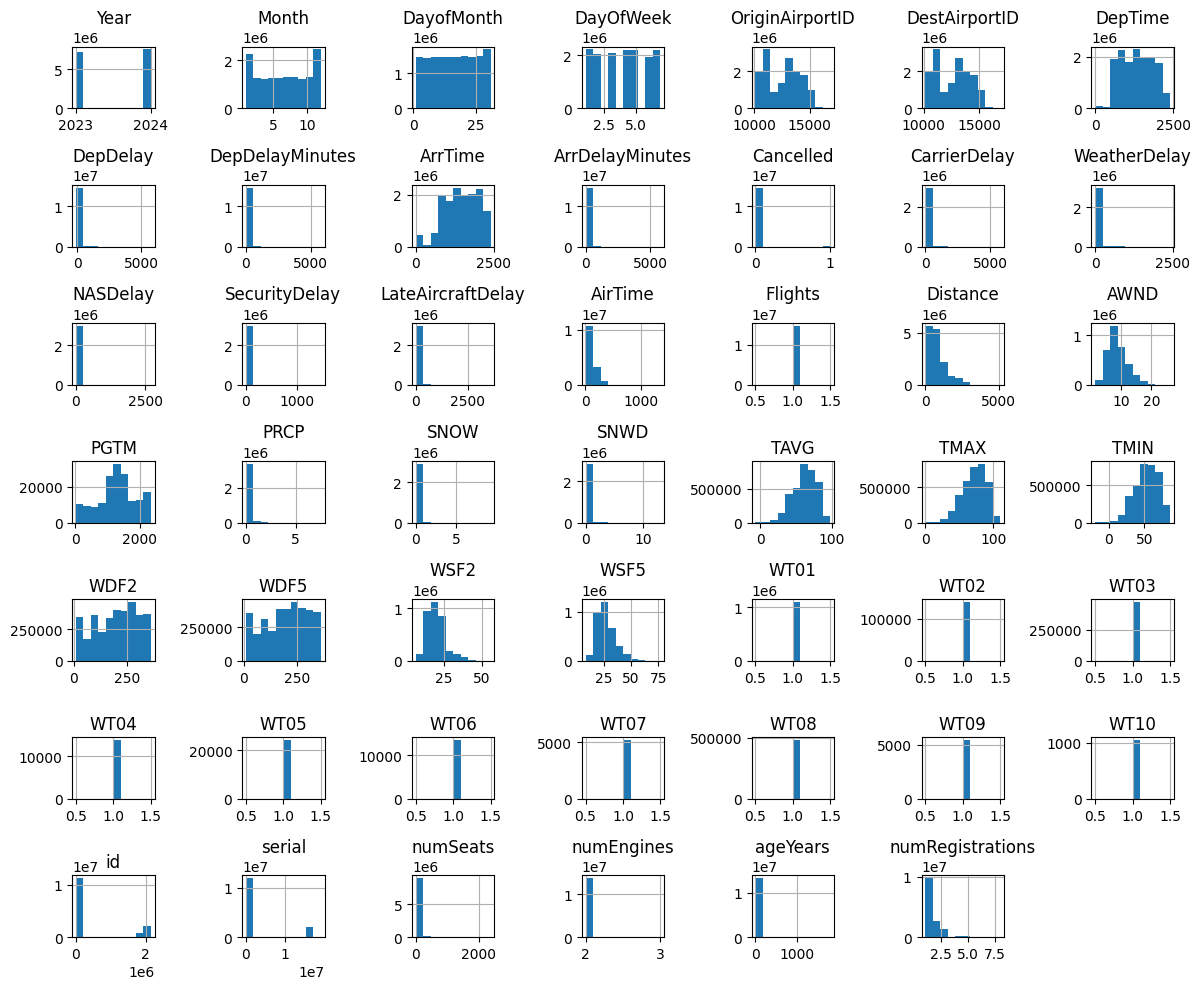

In [9]:
# Plot histograms for all numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns].hist(figsize=(12, 10))
plt.tight_layout()
plt.show()


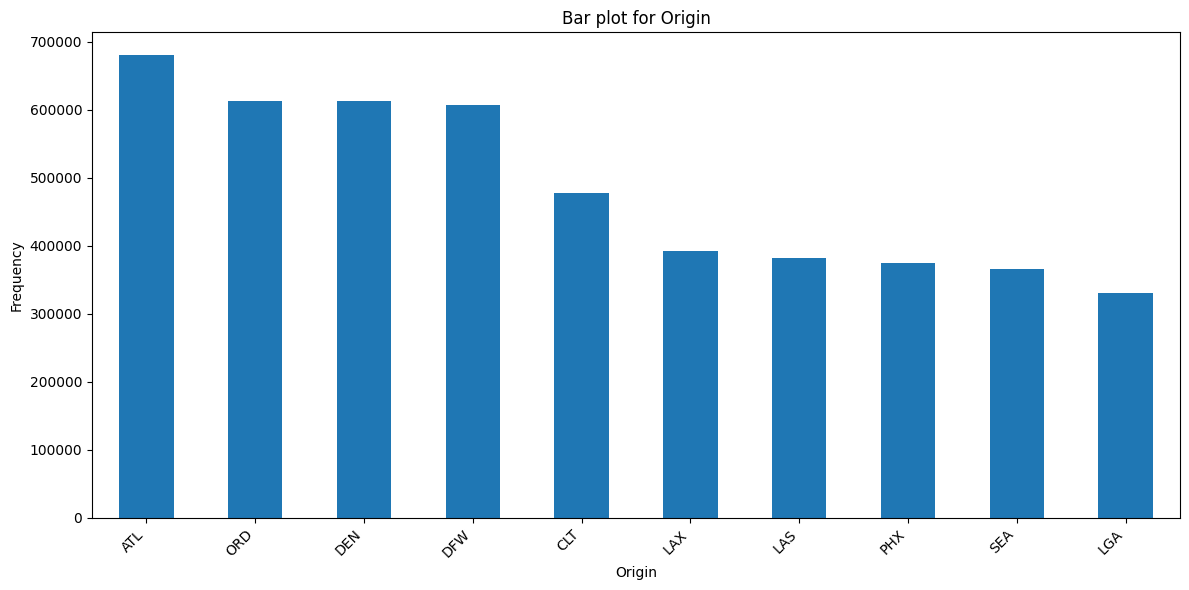

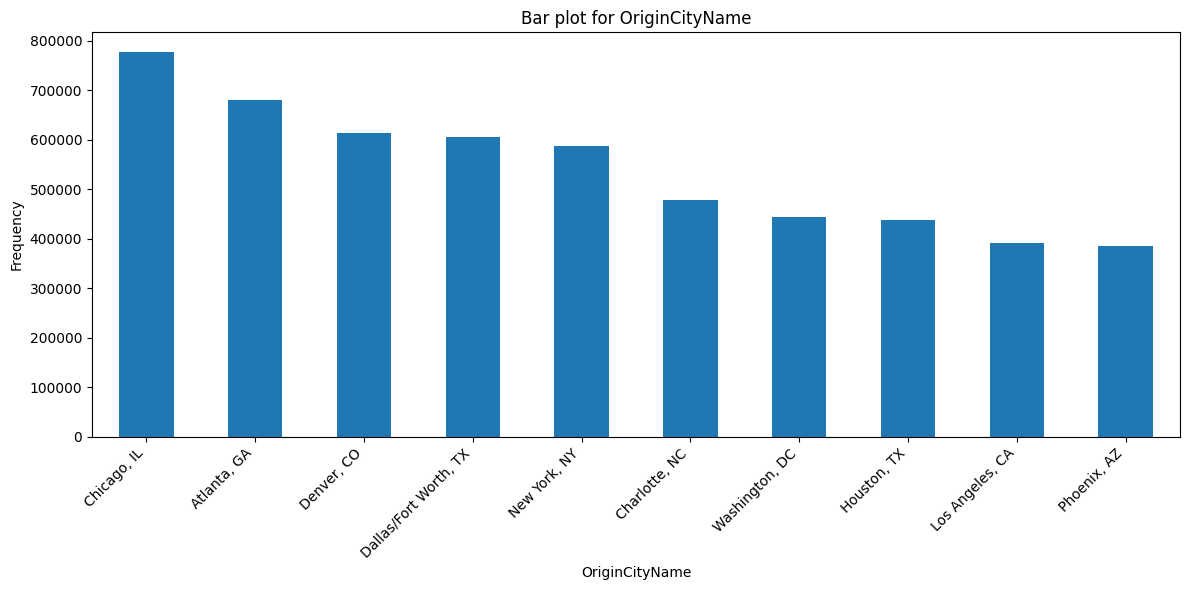

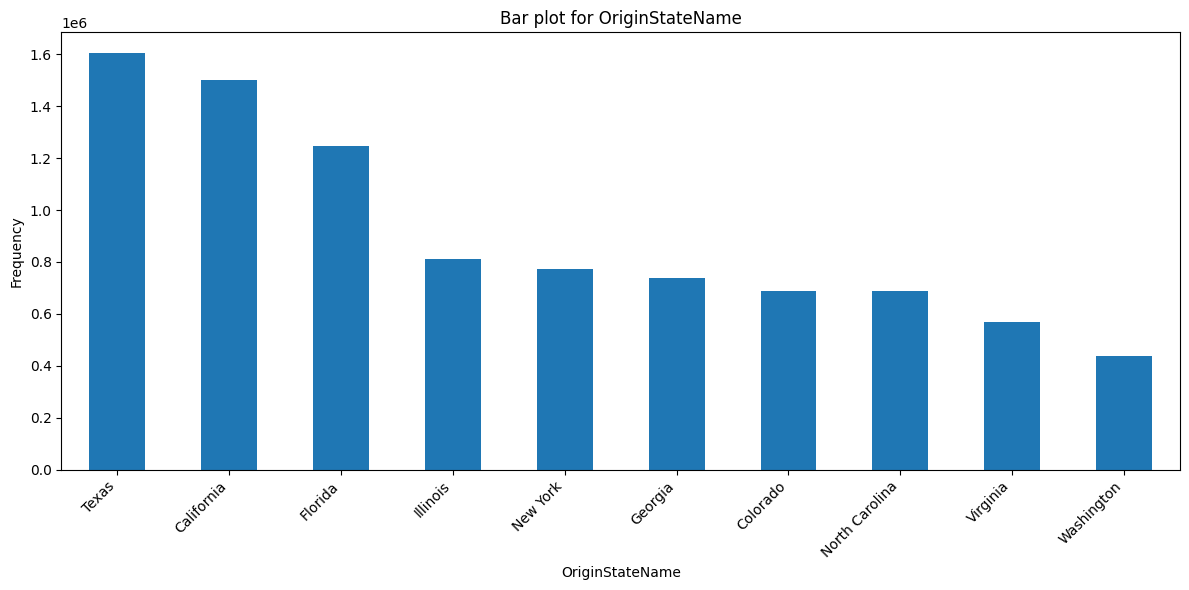

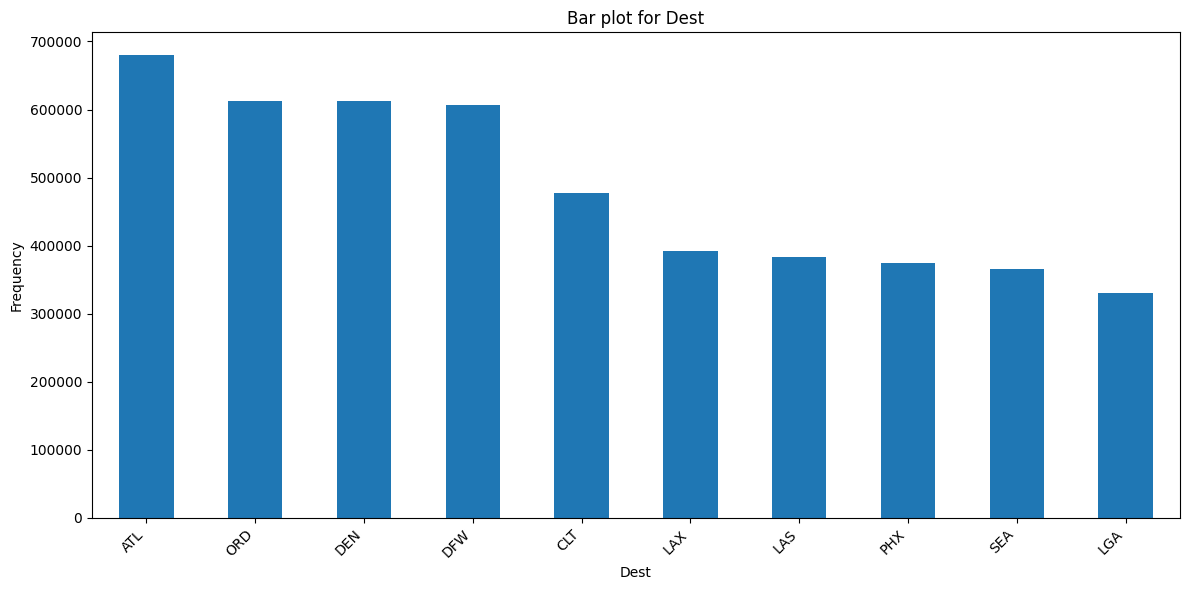

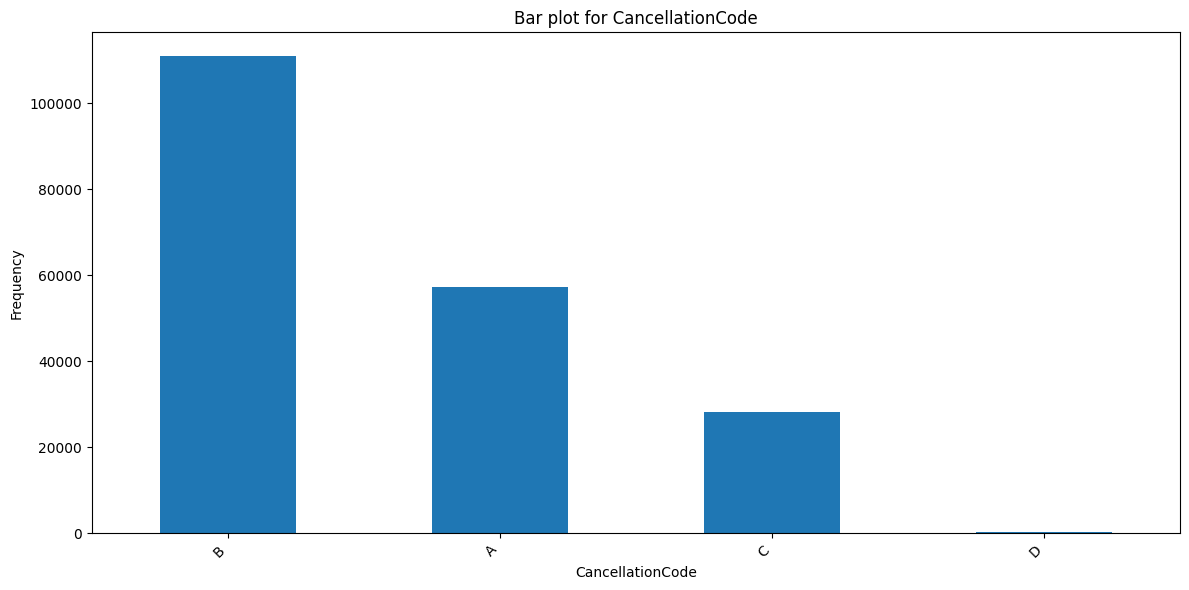

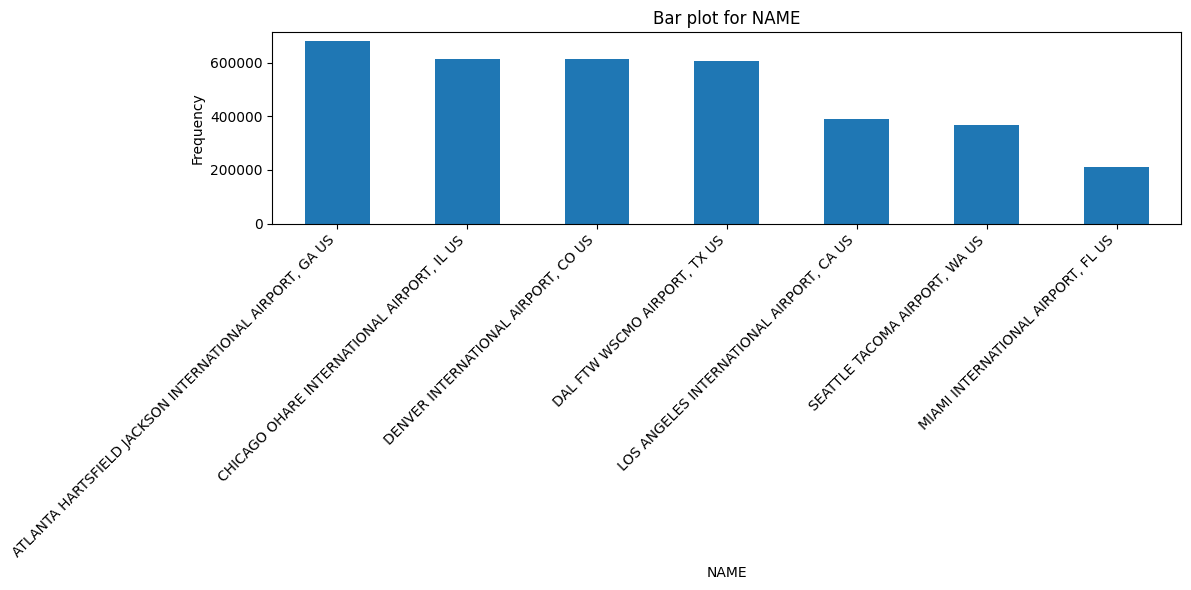

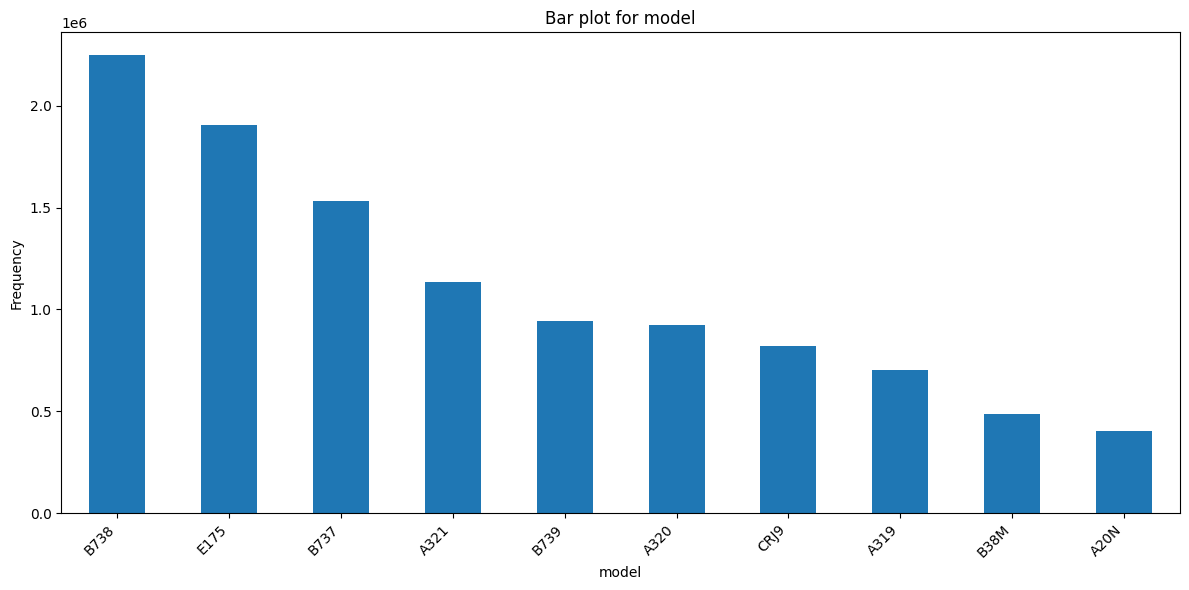

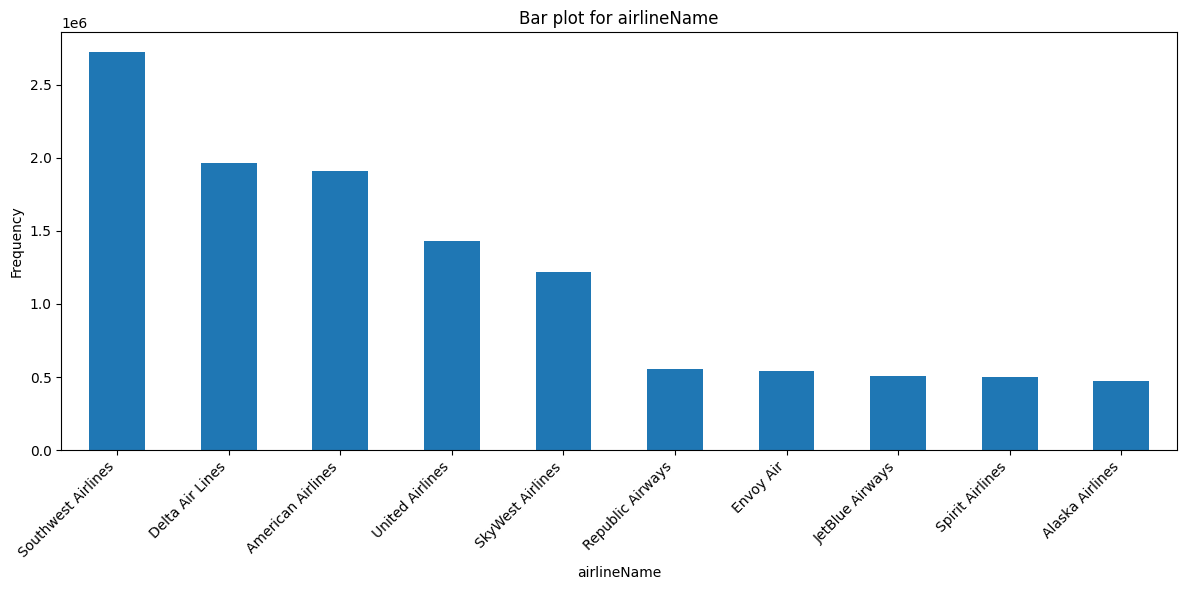

In [10]:
# List of columns to plot bar plots for
columns_to_plot = ['Origin', 'OriginCityName', 'OriginStateName', 'Dest', 'CancellationCode', 'NAME', 'model', 'airlineName']

for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    
    # Count the occurrences of each category
    value_counts = data[column].value_counts()
    
    # Limit to top N categories (e.g., top 10)
    top_n = 10
    value_counts = value_counts.head(top_n)
    
    # Plot the bar plot
    value_counts.plot(kind='bar')
    
    # Set the title and labels
    plt.title(f'Bar plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    # Rotate the x-axis labels for readability
    plt.xticks(rotation=45, ha='right')
    
    # Display the plot
    plt.tight_layout()  # Adjust layout to make space for labels
    plt.show()



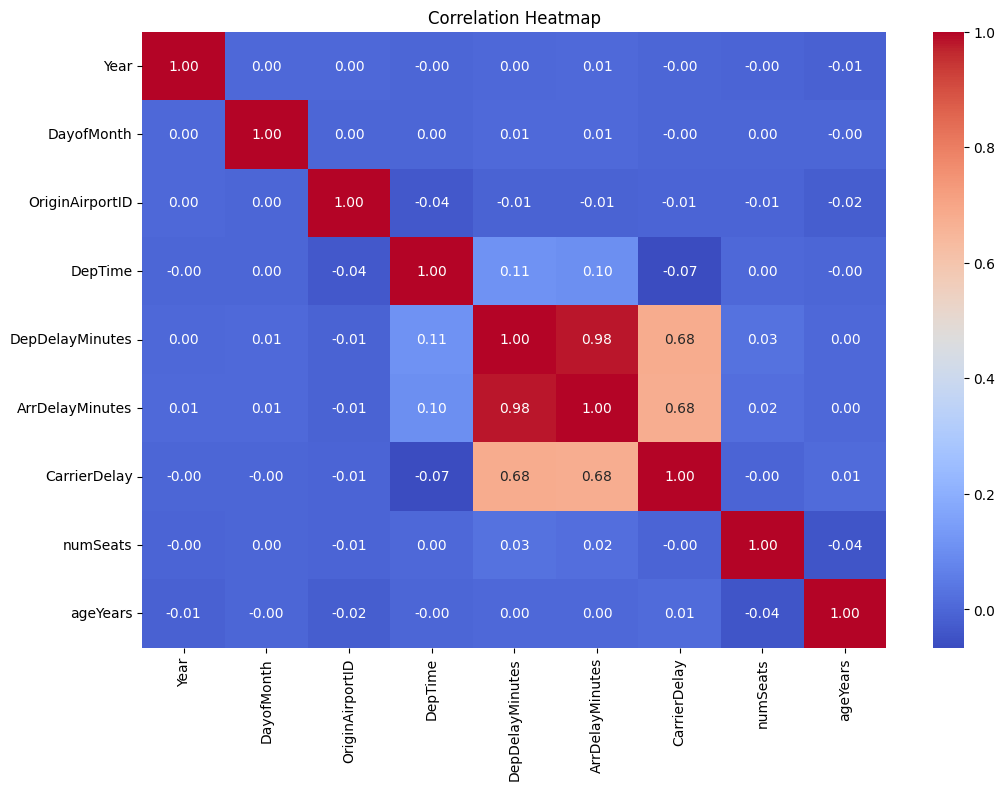

In [11]:


# List of specific columns to compute correlation for
columns_to_include = ['Year', 'DayofMonth', 'OriginAirportID', 'DepTime', 'DepDelayMinutes', 'ArrDelayMinutes', 'CarrierDelay', 'numSeats', 'ageYears']

# Compute correlation matrix for the selected numerical columns
corr_matrix = data[columns_to_include].corr()

# Plot a heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


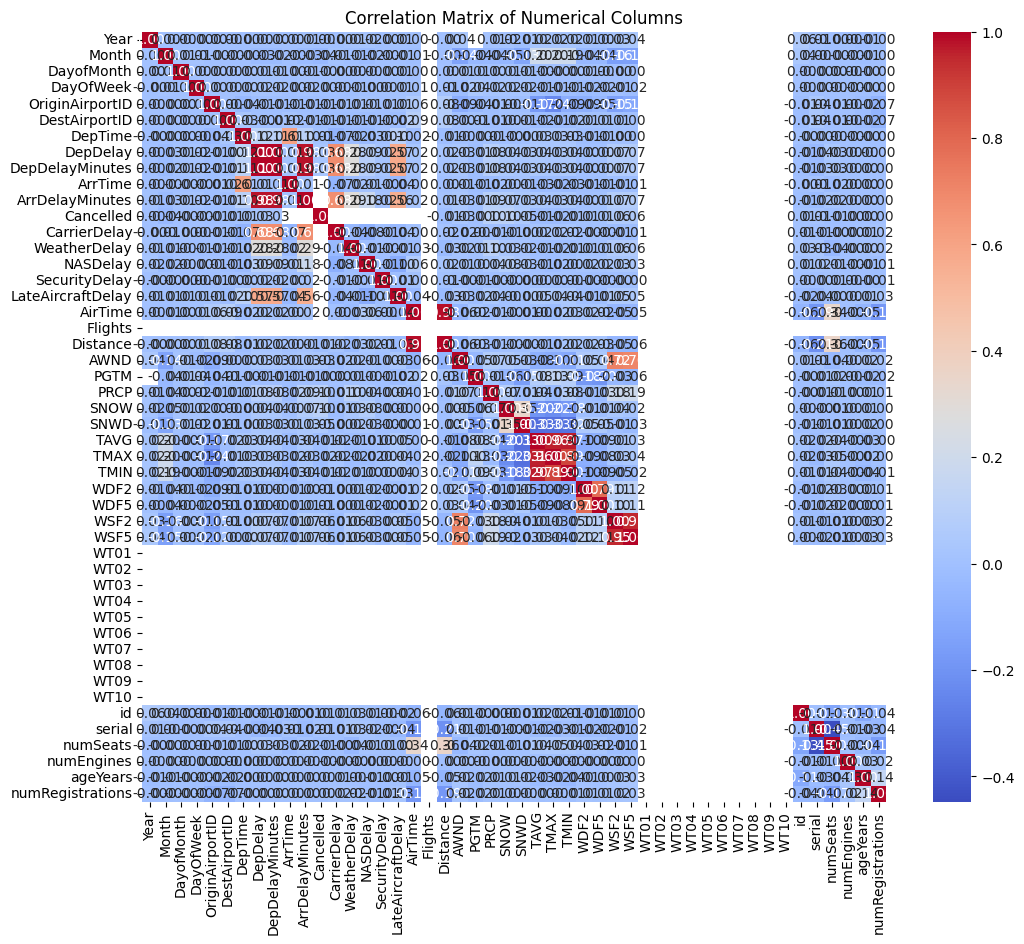

In [12]:

numerical_df = data.select_dtypes(include=['number'])

# Compute the correlation matrix on numerical columns
corr_matrix = numerical_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with annotations
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Set a title for the heatmap
plt.title("Correlation Matrix of Numerical Columns")

# Display the heatmap
plt.show()

In [13]:

corr_pairs = (
    corr_matrix
    .abs()                 # take absolute correlation
    .unstack()            # convert matrix to a Series
    .sort_values(ascending=False)
    .drop_duplicates()    # remove duplicate pairs
)

# Show the top 20 strongest correlations
top_20 = corr_pairs.head(20)
print(top_20)

Year               Year                 1.000000
DepDelayMinutes    DepDelay             0.997870
Distance           AirTime              0.984494
DepDelayMinutes    ArrDelayMinutes      0.982893
DepDelay           ArrDelayMinutes      0.979742
TMIN               TAVG                 0.967805
TAVG               TMAX                 0.961660
WSF5               WSF2                 0.954489
TMIN               TMAX                 0.889773
WDF5               WDF2                 0.789433
WSF2               AWND                 0.722252
WSF5               AWND                 0.701971
DepDelayMinutes    CarrierDelay         0.680750
CarrierDelay       DepDelay             0.680039
ArrDelayMinutes    CarrierDelay         0.677396
DepTime            ArrTime              0.609120
LateAircraftDelay  DepDelay             0.574057
DepDelayMinutes    LateAircraftDelay    0.573788
LateAircraftDelay  ArrDelayMinutes      0.557795
serial             numSeats             0.447487
dtype: float64


In [14]:

corr_pairs = (
    corr_matrix
    .abs()                 # take absolute correlation
    .unstack()            # convert matrix to a Series
    .sort_values(ascending=False)
    .drop_duplicates()    # remove duplicate pairs
)

# Show the top 20 strongest correlations
top_20 = corr_pairs.tail(20)
print(top_20)

OriginAirportID  DayofMonth         0.000164
WDF5             CarrierDelay       0.000142
DayOfWeek        numEngines         0.000142
TMIN             numEngines         0.000141
TAVG             SecurityDelay      0.000141
DayofMonth       WSF5               0.000136
numEngines       TMAX               0.000134
                 DepDelayMinutes    0.000128
DayofMonth       CarrierDelay       0.000121
DestAirportID    WSF5               0.000116
numEngines       WSF2               0.000090
SNOW             OriginAirportID    0.000075
                 ArrTime            0.000073
SecurityDelay    TMAX               0.000056
ArrDelayMinutes  numEngines         0.000045
DepTime          id                 0.000032
numEngines       SecurityDelay      0.000022
ArrTime          numEngines         0.000022
serial           DayofMonth         0.000017
Year             Flights                 NaN
dtype: float64


# Prepare the Data

Note: the word *optional* simply means not all datasets will require it, it does not mean you can just choose not to do it if it is needed for a particular dataset.

1. Data cleaning: Fix/remove outliers (optional); Fill in missing values (with 0, mean, median…) or drop rows/columns

    - Fill in missing values with median
    - Drop WT01 - WT10 columns
    - Drop PGTM column

2. Feature selection (optional): Drop attributes that provide no useful information for the task

3. Feature engineering, where appropriate: Discretize continuous features; Decompose features (categorical, date/time, …), Add promising transformations of features ($\log(x)$, $\sqrt{x}$, $x^2$, …); Aggregate features into promising new features\

    - Create a seasons feature
    - Create a isWeekend feature
    - Create a quarter feature

4. Feature scaling: standardize or normalize features

In [ ]:
# Load the original train file
df = pd.read_parquet("train_set.parquet", engine="pyarrow")

# Drop the 'cancelled' column (use errors='ignore' to avoid errors if the column doesn't exist)
df = df.drop(columns=["Cancelled"], errors="ignore")

# Write the updated DataFrame to a new Parquet file
df.to_parquet("train_set_wo_target.parquet", engine="pyarrow")

print("The file 'train_set_wo_target.parquet' has been saved without the 'cancelled' column.")

The file 'train_set_wo_target.parquet' has been saved without the 'cancelled' column.


: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
import gc
import psutil
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Memory monitoring function
def log_memory_usage(checkpoint_name):
    # Force garbage collection
    gc.collect()
    
    # Get current process
    process = psutil.Process()
    
    # Get memory info in GB
    memory_info = process.memory_info()
    memory_usage = memory_info.rss / (1024 * 1024 * 1024)  # Convert to GB
    
    print(f"Checkpoint: {checkpoint_name} | Memory Usage: {memory_usage:.2f} GB | Time: {time.strftime('%H:%M:%S')}")
    
    return memory_usage

# Custom transformers with improved timestamp handling
class SafeTransformer(BaseEstimator, TransformerMixin):
    """Base class that ensures all datetime columns are converted to numeric"""
    
    def _convert_datetime_columns(self, X):
        """Convert any datetime columns to float timestamps"""
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                if pd.api.types.is_datetime64_any_dtype(X[col]):
                    X[col] = X[col].astype(np.int64) / 10**9
        return X

class MissingMedianTransformer(SafeTransformer):
    """
    Fill missing values with the median for numeric columns.
    """
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        log_memory_usage("Start MissingMedianTransformer fit")
        # Convert datetime columns first
        X = self._convert_datetime_columns(X)
        
        if self.columns is None:
            self.columns = X.select_dtypes(include=[np.number]).columns
        # Store medians in a dictionary instead of a Series to reduce memory
        self.medians_ = {}
        for col in self.columns:
            if col in X.columns:  # Only process columns that exist
                self.medians_[col] = X[col].median()
                # Free memory after each column calculation
                gc.collect()
        log_memory_usage("End MissingMedianTransformer fit")
        return self
        
    def transform(self, X, y=None):
        log_memory_usage("Start MissingMedianTransformer transform")
        X_transformed = X.copy()
        
        # Convert datetime columns first
        X_transformed = self._convert_datetime_columns(X_transformed)
        
        # Process columns in batches to reduce peak memory
        for i, col in enumerate(self.columns):
            if col in X_transformed.columns:  # Only process columns that exist
                X_transformed[col] = X_transformed[col].fillna(self.medians_[col])
                if i % 10 == 0:  # Log every 10 columns
                    gc.collect()
        log_memory_usage("End MissingMedianTransformer transform")
        return X_transformed

class DropColumnsTransformer(SafeTransformer):
    """
    Drop specified columns.
    """
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        log_memory_usage("Start DropColumnsTransformer transform")
        X_transformed = X.copy()
        
        # Convert datetime columns first
        X_transformed = self._convert_datetime_columns(X_transformed)
        
        result = X_transformed.drop(columns=self.columns, errors='ignore')
        log_memory_usage("End DropColumnsTransformer transform")
        return result

class DateHandler(SafeTransformer):
    """
    Comprehensive date handler that extracts features and converts any datetime columns.
    """
    def __init__(self, date_column='FlightDate'):
        self.date_column = date_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        log_memory_usage("Start DateHandler transform")
        X_transformed = X.copy()
        
        # First, convert all datetime columns to datetime type
        for col in X_transformed.columns:
            if pd.api.types.is_datetime64_any_dtype(X_transformed[col]) or (
                    pd.api.types.is_object_dtype(X_transformed[col]) and 
                    X_transformed[col].dtypes == 'object'):
                try:
                    X_transformed[col] = pd.to_datetime(X_transformed[col], errors='coerce')
                except:
                    # If conversion fails, we'll handle this column differently
                    continue
        
        # Extract features from the main date column if it exists
        if self.date_column in X_transformed.columns:
            try:
                # Convert to datetime if not already
                X_transformed[self.date_column] = pd.to_datetime(X_transformed[self.date_column], errors='coerce')
                
                # Extract features
                X_transformed['Year'] = X_transformed[self.date_column].dt.year
                X_transformed['Month'] = X_transformed[self.date_column].dt.month
                X_transformed['Day'] = X_transformed[self.date_column].dt.day
                X_transformed['DayOfWeek'] = X_transformed[self.date_column].dt.dayofweek + 1
                X_transformed['Quarter'] = X_transformed[self.date_column].dt.quarter
                
                # Create season feature
                season_map = {
                    1: 'Winter', 2: 'Winter', 12: 'Winter',
                    3: 'Spring', 4: 'Spring', 5: 'Spring',
                    6: 'Summer', 7: 'Summer', 8: 'Summer',
                    9: 'Fall', 10: 'Fall', 11: 'Fall'
                }
                X_transformed['Season'] = X_transformed[self.date_column].dt.month.map(season_map)
                
                # Create weekend feature if DayOfWeek is available
                X_transformed['isWeekend'] = np.where(X_transformed['DayOfWeek'].isin([6, 7]), 1, 0)
                
                # Drop the original date column
                X_transformed = X_transformed.drop(columns=[self.date_column])
            except Exception as e:
                print(f"Error processing date column {self.date_column}: {e}")
                # Keep moving even if we can't process the main date column
        
        # Convert ANY remaining datetime columns to numeric timestamps
        X_transformed = self._convert_datetime_columns(X_transformed)
        
        log_memory_usage("End DateHandler transform")
        return X_transformed

def process_parquet_in_chunks(parquet_file, pipeline, chunk_size=1000, save_path=None):
    """
    Process a large Parquet file in chunks to manage memory usage.
    Uses manual chunk reading since pandas doesn't support chunksize for parquet.
    
    Parameters:
    -----------
    parquet_file : str
        Path to the Parquet file containing the data.
    pipeline : Pipeline
        Scikit-learn pipeline to use for processing.
    chunk_size : int, default=1000
        Number of rows in each chunk.
    save_path : str, optional
        If provided, processed chunks will be saved to this path.
        
    Returns:
    --------
    None or DataFrame
        If save_path is provided, returns None; otherwise returns the processed DataFrame.
    """
    log_memory_usage(f"Starting Parquet processing with chunk_size={chunk_size}")
    
    # Get file info first
    log_memory_usage("Reading metadata")
    try:
        # Get a small sample just to examine the file
        sample_df = pd.read_parquet(parquet_file, engine='pyarrow').head(10)
        print("Column info:")
        for col in sample_df.columns:
            print(f"  {col}: {sample_df[col].dtype}")
            
        # For datetime columns specifically check
        date_cols = [col for col in sample_df.columns 
                     if pd.api.types.is_datetime64_any_dtype(sample_df[col])]
        if date_cols:
            print(f"Date columns found: {date_cols}")
    except Exception as e:
        print(f"Error examining data: {e}")
    
    # Get total number of rows to determine number of chunks
    try:
        import pyarrow.parquet as pq
        file_metadata = pq.read_metadata(parquet_file)
        total_rows = file_metadata.num_rows
        print(f"Total rows in parquet file: {total_rows}")
    except Exception as e:
        print(f"Error with PyArrow: {e}")
        # Fallback method if PyArrow is not installed or fails
        print("Using pandas to get row count")
        total_rows = pd.read_parquet(parquet_file, columns=[]).shape[0]
    
    log_memory_usage(f"Parquet file has {total_rows} rows")
    
    # Create temporary directory for chunks if saving
    if save_path and save_path.endswith('.parquet'):
        temp_dir = save_path.replace('.parquet', '_chunks')
        os.makedirs(temp_dir, exist_ok=True)
    
    # Read the first chunk to fit the pipeline
    fit_chunk_size = min(chunk_size, 10000)  # Use a smaller size for fitting
    
    try:
        log_memory_usage("Reading first chunk for fitting")
        first_chunk = pd.read_parquet(parquet_file, engine='pyarrow').iloc[:fit_chunk_size].copy()
        log_memory_usage(f"Loaded first chunk with {len(first_chunk)} rows")
        
        # Convert all datetime columns to numeric for first chunk
        for col in first_chunk.columns:
            if pd.api.types.is_datetime64_any_dtype(first_chunk[col]):
                print(f"Converting datetime column '{col}' to numeric for fitting")
                first_chunk[col] = pd.to_datetime(first_chunk[col]).astype(np.int64) / 10**9
        
        # Also try to convert string columns that might contain dates
        for col in first_chunk.columns:
            if first_chunk[col].dtype == 'object':
                try:
                    # Try to convert to datetime first
                    datetime_col = pd.to_datetime(first_chunk[col], errors='coerce')
                    # If most values were successfully converted, use the numeric version
                    if datetime_col.notna().mean() > 0.5:  # If more than 50% converted successfully
                        print(f"Converting string column '{col}' to datetime then numeric")
                        first_chunk[col] = datetime_col.astype(np.int64) / 10**9
                except:
                    pass  # Leave as is if conversion fails
        
        # Fit the pipeline on the first chunk
        print("Fitting pipeline on first chunk...")
        pipeline.fit(first_chunk)
        log_memory_usage("Pipeline fitted on first chunk")
        
        # Delete the first chunk to free memory
        del first_chunk
        gc.collect()
        
        # Process the data in chunks
        num_chunks = (total_rows + chunk_size - 1) // chunk_size  # Ceiling division
        
        if save_path:
            # If save path is provided, process and save chunks incrementally
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_size
                end_idx = min((chunk_idx + 1) * chunk_size, total_rows)
                
                log_memory_usage(f"Processing chunk {chunk_idx+1}/{num_chunks} (rows {start_idx}-{end_idx-1})")
                
                # Read chunk
                try:
                    chunk = pd.read_parquet(
                        parquet_file,
                        engine='pyarrow'
                    ).iloc[start_idx:end_idx].copy()
                    
                    log_memory_usage(f"Loaded chunk with {len(chunk)} rows")
                    
                    # Pre-process the chunk to avoid datetime issues
                    # Convert all datetime columns to numeric
                    for col in chunk.columns:
                        if pd.api.types.is_datetime64_any_dtype(chunk[col]):
                            chunk[col] = pd.to_datetime(chunk[col]).astype(np.int64) / 10**9
                    
                    # Transform the chunk
                    processed_chunk = pipeline.transform(chunk)
                    log_memory_usage(f"Transformed chunk {chunk_idx+1}/{num_chunks}")
                    
                    # Convert to DataFrame if it's a numpy array
                    if isinstance(processed_chunk, np.ndarray):
                        column_names = [f"feature_{i}" for i in range(processed_chunk.shape[1])]
                        processed_chunk = pd.DataFrame(processed_chunk, columns=column_names)
                    
                    # Save the processed chunk
                    if save_path.endswith('.parquet'):
                        # For parquet, save as separate files and combine later
                        chunk_path = f"{temp_dir}/chunk_{chunk_idx}.parquet"
                        processed_chunk.to_parquet(chunk_path, engine='pyarrow')
                    else:
                        # For CSV, we can append
                        mode = 'w' if chunk_idx == 0 else 'a'
                        header = chunk_idx == 0
                        processed_chunk.to_csv(save_path, mode=mode, header=header, index=False)
                    
                    log_memory_usage(f"Saved chunk {chunk_idx+1}/{num_chunks}")
                    
                except Exception as e:
                    print(f"Error processing chunk {chunk_idx+1}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
                
                # Clean up to free memory
                try:
                    del chunk, processed_chunk
                    gc.collect()
                except:
                    pass
                
            # If we saved as parquet chunks, combine them
            if save_path.endswith('.parquet') and os.path.exists(temp_dir):
                log_memory_usage("Combining parquet chunks")
                \


                
                # List all chunk files
                chunk_files = sorted([os.path.join(temp_dir, f) for f in os.listdir(temp_dir) 
                                    if f.startswith('chunk_') and f.endswith('.parquet')])
                
                if chunk_files:
                    try:
                        # Read the first chunk to get schema
                        combined_df = pd.read_parquet(chunk_files[0])
                        
                        # Append other chunks one by one to avoid memory issues
                        for i, chunk_file in enumerate(chunk_files[1:], 1):
                            log_memory_usage(f"Combining chunk {i}/{len(chunk_files)-1}")
                            try:
                                chunk_df = pd.read_parquet(chunk_file)
                                combined_df = pd.concat([combined_df, chunk_df], ignore_index=True)
                                del chunk_df
                                gc.collect()
                            except Exception as e:
                                print(f"Error combining chunk {i}: {e}")
                        
                        # Save the combined DataFrame
                        log_memory_usage("Saving final combined parquet file")
                        combined_df.to_parquet(save_path, engine='pyarrow')
                        del combined_df
                        gc.collect()
                    except Exception as e:
                        print(f"Error in final combination: {e}")
                        import traceback
                        traceback.print_exc()
                        
                        # If combination fails, at least keep the chunk files
                        print(f"Individual chunks are still available in {temp_dir}/")
                        return None
                    
                    # Clean up temp files
                    log_memory_usage("Cleaning up temporary files")
                    for chunk_file in chunk_files:
                        try:
                            os.remove(chunk_file)
                        except:
                            pass
                    try:
                        os.rmdir(temp_dir)
                    except:
                        pass
                
            print(f"All chunks processed and saved to {save_path}")
            return None
        else:
            # If no save path is provided, store processed chunks in memory and combine at the end
            processed_chunks = []
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_size
                end_idx = min((chunk_idx + 1) * chunk_size, total_rows)
                
                log_memory_usage(f"Processing chunk {chunk_idx+1}/{num_chunks} (rows {start_idx}-{end_idx-1})")
                
                # Read chunk
                try:
                    chunk = pd.read_parquet(
                        parquet_file,
                        engine='pyarrow'
                    ).iloc[start_idx:end_idx].copy()
                    
                    log_memory_usage(f"Loaded chunk with {len(chunk)} rows")
                    
                    # Pre-process the chunk to avoid datetime issues
                    # Convert all datetime columns to numeric
                    for col in chunk.columns:
                        if pd.api.types.is_datetime64_any_dtype(chunk[col]):
                            chunk[col] = pd.to_datetime(chunk[col]).astype(np.int64) / 10**9
                    
                    # Transform the chunk
                    processed_chunk = pipeline.transform(chunk)
                    log_memory_usage(f"Transformed chunk {chunk_idx+1}/{num_chunks}")
                    
                    # Convert to DataFrame if it's a numpy array
                    if isinstance(processed_chunk, np.ndarray):
                        try:
                            # Attempt to get output feature names from the ColumnTransformer
                            names = pipeline.named_steps['column_transformer'].get_feature_names_out()
                        except Exception as e:
                            # Fallback: use the chunk's original columns (if they match)
                            names = chunk.columns
                        processed_chunk = pd.DataFrame(processed_chunk, columns=names)
                    
                    processed_chunks.append(processed_chunk)
                except Exception as e:
                    print(f"Error processing chunk {chunk_idx+1}: {e}")
                    continue
                
                # Clean up to free memory
                del chunk
                gc.collect()
            
            # Combine all processed chunks
            log_memory_usage("Combining all processed chunks")
            result = pd.concat(processed_chunks, ignore_index=True)
            log_memory_usage("All chunks combined")
            
            # Clean up to free memory
            del processed_chunks
            gc.collect()
            
            return result
    
    except Exception as e:
        print(f"Critical error in processing: {e}")
        import traceback
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    # Define your pipeline components
    drop_cols = [f'WT{i:02d}' for i in range(1, 11)] + ['PGTM']
    
    # Create a simplified pipeline that properly handles datetime
    preprocessor = Pipeline([
        # Step 1: Handle all date columns and conversions
        ('date_handler', DateHandler(date_column='FlightDate')),
        
        # Step 2: Data Cleaning (after dates are handled)
        ('data_cleaning', Pipeline(steps=[
            ('fill_median', MissingMedianTransformer()),
            ('drop_columns', DropColumnsTransformer(columns=drop_cols))
        ])),
        
        # Step 3: Column-wise Processing
        ('column_transformer', ColumnTransformer(transformers=[
            ('numerical', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), lambda df: df.select_dtypes(include=[np.number]).columns.tolist()),
            
            ('categorical', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), lambda df: df.select_dtypes(include=['object']).columns.tolist()),
        ], remainder='drop'))  # Use 'drop' to avoid issues with unhandled types
    ])
    
    # Set the file paths - MODIFY THESE TO YOUR ACTUAL PATHS
    train_file = 'train_set_wo_target.parquet'
    test_file = 'test_set.parquet'
    
    # Process training data with optimized memory usage
    # Option C: Process in chunks and save to disk (least memory usage)
    process_parquet_in_chunks(train_file, preprocessor, chunk_size=100000, save_path='processed_train.parquet')
    
    

Checkpoint: Starting Parquet processing with chunk_size=100000 | Memory Usage: 0.19 GB | Time: 21:14:17
Checkpoint: Reading metadata | Memory Usage: 0.19 GB | Time: 21:14:17
Column info:
  Year: int64
  Month: int64
  DayofMonth: int64
  DayOfWeek: int64
  FlightDate: datetime64[ns]
  OriginAirportID: int64
  Origin: object
  OriginCityName: object
  OriginStateName: object
  DestAirportID: int64
  Dest: object
  DestCityName: object
  DestStateName: object
  DepTime: float64
  DepDelay: float64
  DepDelayMinutes: float64
  ArrTime: float64
  ArrDelayMinutes: float64
  CancellationCode: object
  CarrierDelay: float64
  Tail_Number: object
  WeatherDelay: float64
  NASDelay: float64
  SecurityDelay: float64
  LateAircraftDelay: float64
  AirTime: float64
  Flights: float64
  Distance: float64
  WeatherStation: object
  NAME: object
  DATE: datetime64[ns]
  AWND: float64
  PGTM: float64
  PRCP: float64
  SNOW: float64
  SNWD: float64
  TAVG: float64
  TMAX: float64
  TMIN: float64
  WDF2

In [5]:
processed = pd.read_parquet('processed_train.parquet')
processed.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69
0,0.0,0.0,-0.191316,0.0,1.747925,0.000002,0.000002,0.000002,1.209211,0.000002,...,0.000002,0.000002,0.472470,0.000002,0.612928,0.094102,0.0,0.0,0.0,1.0
1,0.0,0.0,-1.562345,0.0,-1.260947,0.000002,0.000002,0.000002,1.209211,0.000002,...,0.000002,0.000002,-0.445153,0.000002,-0.548581,0.345468,0.0,0.0,0.0,1.0
2,0.0,0.0,-1.448092,0.0,0.162408,0.000002,0.000002,0.000002,0.924166,0.000002,...,0.000002,0.000002,0.115616,0.000002,-0.548581,0.191810,0.0,0.0,0.0,1.0
3,0.0,0.0,-0.305568,0.0,1.214823,0.000002,0.000002,0.000002,-0.110516,0.000002,...,0.000002,0.000002,-0.129083,0.000002,-0.548581,0.259002,0.0,0.0,0.0,1.0
4,0.0,0.0,-0.419820,0.0,0.845854,0.000002,0.000002,0.000002,0.352109,0.000002,...,0.000002,0.000002,0.380707,0.000002,1.774438,0.118806,0.0,0.0,0.0,1.0


Short-List Promising Models
======
1. Train many quick and dirty models from different categories (e.g. linear, naive
Bayes, SVM, Random Forests, neural net, ...) using standard parameters
2. Measure and compare their performance. For each model, use 𝑁𝑁-fold cross-
validation and compute the mean and standard deviation of the performance
measure on the 𝑁𝑁 folds.
3. Analyze the most significant variables for each algorithm
4. Analyze the types of errors the models make. What data would a human have used to avoid these errors?
5. Have a quick round of feature selection and engineering
6. Have one or two more quick iterations of the five previous steps
7. Short-list the top three to five most promising models, preferring models that make different types of errors

Try all 7 model and then take the two best and fine tune the hyperparameters

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import classifiers and utilities from scikit-learn
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load your pre-processed feature data (the Cancelled column has been dropped)
X = pd.read_parquet('processed_train.parquet')

# Load the target variable from a separate file (adjust filename and column as needed)
y = pd.read_parquet('final_data.parquet')['Cancelled']

# Set up stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
# Check the shapes
print("Features shape:", X.shape)   # (11860565, 69)
print("Target shape:", y.shape)       # (14825707,)

# Align using the intersection of indices
common_idx = X.index.intersection(y.index)
print("Common index shape:", common_idx.shape)

X_aligned = X.loc[common_idx]
y_aligned = y.loc[common_idx]

print("Aligned Features shape:", X_aligned.shape)
print("Aligned Target shape:", y_aligned.shape)

Features shape: (11860565, 69)
Target shape: (14825707,)
Common index shape: (11860565,)
Aligned Features shape: (11860565, 69)
Aligned Target shape: (11860565,)


Logistic Regression
-----

In [10]:
print("=== LogisticRegression ===")
lr = LogisticRegression(max_iter=1000, solver='lbfgs')

# Cross-validation evaluation
scores = cross_val_score(lr, X_aligned, y_aligned, cv=cv, scoring='accuracy')
print("CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(np.mean(scores), np.std(scores)))

# Error analysis using cross_val_predict
y_pred = cross_val_predict(lr, X_aligned, y_aligned, cv=cv)
print("\nConfusion Matrix:")
print(confusion_matrix(y_aligned, y_pred))
print("\nClassification Report:")
print(classification_report(y_aligned, y_pred))

# Feature importance analysis (using coefficients)
lr.fit(X_aligned, y_aligned)
if hasattr(lr, 'coef_'):
    coefs = lr.coef_[0] if lr.coef_.ndim > 1 else lr.coef_
    importance = np.abs(coefs)
    sorted_idx = np.argsort(importance)[::-1]
    print("\nTop 10 Features (by coefficient magnitude):")
    for i in sorted_idx[:10]:
        print(f"{X.columns[i]:20s}: {importance[i]:.4f}")

=== LogisticRegression ===
CV Accuracy: Mean = 0.9859, Std = 0.0000

Confusion Matrix:
[[11693191        0]
 [  167374        0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99  11693191
         1.0       0.00      0.00      0.00    167374

    accuracy                           0.99  11860565
   macro avg       0.49      0.50      0.50  11860565
weighted avg       0.97      0.99      0.98  11860565


Top 10 Features (by coefficient magnitude):
feature_68          : 2.1257
feature_12          : 0.0067
feature_64          : 0.0066
feature_54          : 0.0052
feature_51          : 0.0049
feature_15          : 0.0046
feature_8           : 0.0040
feature_63          : 0.0038
feature_29          : 0.0035
feature_61          : 0.0034


SGD Classifier
-----

In [13]:
print("=== SGDClassifier ===")
sgd = SGDClassifier(max_iter=1000, tol=1e-3)

# Cross-validation evaluation
scores = cross_val_score(sgd, X_aligned, y_aligned, cv=cv, scoring='accuracy')
print("CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(np.mean(scores), np.std(scores)))

# Error analysis using cross_val_predict
y_pred = cross_val_predict(sgd, X_aligned, y_aligned, cv=cv)
print("\nConfusion Matrix:")
print(confusion_matrix(y_aligned, y_pred))
print("\nClassification Report:")
print(classification_report(y_aligned, y_pred))

# Feature importance analysis (using coefficients)
sgd.fit(X_aligned, y_aligned)
if hasattr(sgd, 'coef_'):
    coefs = sgd.coef_[0] if sgd.coef_.ndim > 1 else sgd.coef_
    importance = np.abs(coefs)
    sorted_idx = np.argsort(importance)[::-1]
    print("\nTop 10 Features (by coefficient magnitude):")
    for i in sorted_idx[:10]:
        print(f"{X.columns[i]:20s}: {importance[i]:.4f}")

=== SGDClassifier ===
CV Accuracy: Mean = 0.9859, Std = 0.0000

Confusion Matrix:
[[11693191        0]
 [  167374        0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99  11693191
         1.0       0.00      0.00      0.00    167374

    accuracy                           0.99  11860565
   macro avg       0.49      0.50      0.50  11860565
weighted avg       0.97      0.99      0.98  11860565


Top 10 Features (by coefficient magnitude):
feature_68          : 0.6341
feature_61          : 0.0100
feature_18          : 0.0040
feature_57          : 0.0034
feature_64          : 0.0031
feature_55          : 0.0025
feature_32          : 0.0023
feature_14          : 0.0017
feature_13          : 0.0016
feature_33          : 0.0014


MLP Classifier
-----

In [14]:
print("=== MLPClassifier ===")
mlp = MLPClassifier(max_iter=500)

# Cross-validation evaluation
scores = cross_val_score(mlp, X_aligned, y_aligned, cv=cv, scoring='accuracy')
print("CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(np.mean(scores), np.std(scores)))

# Error analysis using cross_val_predict
y_pred = cross_val_predict(mlp, X_aligned, y_aligned, cv=cv)
print("\nConfusion Matrix:")
print(confusion_matrix(y_aligned, y_pred))
print("\nClassification Report:")
print(classification_report(y_aligned, y_pred))

# MLPClassifier does not expose feature importance (i.e. no coef_ or feature_importances_)
print("\nNote: MLPClassifier does not provide direct feature importance measures.")

=== MLPClassifier ===


: 

: 

DecisionTreeClassifier
-----

In [ ]:
print("=== DecisionTreeClassifier ===")
dt = DecisionTreeClassifier()

# Cross-validation evaluation
scores = cross_val_score(dt, X_aligned, y_aligned, cv=cv, scoring='accuracy')
print("CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(np.mean(scores), np.std(scores)))

# Error analysis using cross_val_predict
y_pred = cross_val_predict(dt, X_aligned, y_aligned, cv=cv)
print("\nConfusion Matrix:")
print(confusion_matrix(y_aligned, y_pred))
print("\nClassification Report:")
print(classification_report(y_aligned, y_pred))

# Feature importance analysis (using feature_importances_)
dt.fit(X_aligned, y_aligned)
if hasattr(dt, 'feature_importances_'):
    importances = dt.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    print("\nTop 10 Features (by importance):")
    for i in sorted_idx[:10]:
        print(f"{X.columns[i]:20s}: {importances[i]:.4f}")

RandomForestClassifier
-----

In [ ]:
print("=== RandomForestClassifier ===")
rf = RandomForestClassifier()

# Cross-validation evaluation
scores = cross_val_score(rf, X_aligned, y_aligned, cv=cv, scoring='accuracy')
print("CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(np.mean(scores), np.std(scores)))

# Error analysis using cross_val_predict
y_pred = cross_val_predict(rf, X_aligned, y_aligned, cv=cv)
print("\nConfusion Matrix:")
print(confusion_matrix(y_aligned, y_pred))
print("\nClassification Report:")
print(classification_report(y_aligned, y_pred))

# Feature importance analysis (using feature_importances_)
rf.fit(X_aligned, y_aligned)
if hasattr(rf, 'feature_importances_'):
    importances = rf.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    print("\nTop 10 Features (by importance):")
    for i in sorted_idx[:10]:
        print(f"{X.columns[i]:20s}: {importances[i]:.4f}")

ExtraTreesClassifier
-----

In [ ]:
print("=== ExtraTreesClassifier ===")
etc = ExtraTreesClassifier()

# Cross-validation evaluation
scores = cross_val_score(etc, X, y, cv=cv, scoring='accuracy')
print("CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(np.mean(scores), np.std(scores)))

# Error analysis using cross_val_predict
y_pred = cross_val_predict(etc, X, y, cv=cv)
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Feature importance analysis (using feature_importances_)
etc.fit(X, y)
if hasattr(etc, 'feature_importances_'):
    importances = etc.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    print("\nTop 10 Features (by importance):")
    for i in sorted_idx[:10]:
        print(f"{X.columns[i]:20s}: {importances[i]:.4f}")

GradientBoostingClassifier
-----

In [ ]:
print("=== GradientBoostingClassifier ===")
gb = GradientBoostingClassifier()

# Cross-validation evaluation
scores = cross_val_score(gb, X, y, cv=cv, scoring='accuracy')
print("CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(np.mean(scores), np.std(scores)))

# Error analysis using cross_val_predict
y_pred = cross_val_predict(gb, X, y, cv=cv)
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Feature importance analysis (using feature_importances_)
gb.fit(X, y)
if hasattr(gb, 'feature_importances_'):
    importances = gb.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    print("\nTop 10 Features (by importance):")
    for i in sorted_idx[:10]:
        print(f"{X.columns[i]:20s}: {importances[i]:.4f}")

KNeighborsClassifiers
-----

In [ ]:
print("=== KNeighborsClassifier ===")
knn = KNeighborsClassifier()

# Cross-validation evaluation
scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
print("CV Accuracy: Mean = {:.4f}, Std = {:.4f}".format(np.mean(scores), np.std(scores)))

# Error analysis using cross_val_predict
y_pred = cross_val_predict(knn, X, y, cv=cv)
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Note: KNeighborsClassifier does not provide feature importance measures.
print("\nNote: KNeighborsClassifier does not expose feature importance (no coef_ or feature_importances_).")

Fine-Tune the System
======
1. Fine-tune the hyperparameters using cross-validation. Treat your data
transformation choices as hyperparameters, especially when you are not sure
about them. Unless there are very few hyperparameter values to explore, prefer
random search over grid search. If training is very long, you may prefer a Bayesian
optimization approach.
2. Try Ensemble methods. Combining your best models will often perform better
than running them individually.
3. Once you are confident about your final model, measure its performance on the
test set to estimate the generalization error.

Present Your Solution
=====
1. Document what you have done
2. Create a nice presentation, highlighting the big picture first
3. Explain why your solution achieves the business objective
4. Don’t forget to present interesting points you noticed along the way: Describe what worked and what did not; List your
assumptions and your system’s limitations
5. Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements (e.g. “the
median income is the number-one predictor of housing prices”)